# Setup

In [1]:
!pip install coclust

In [34]:
import os
if 'REPORT_PROJECT' in os.environ:
    report_project = os.environ['REPORT_PROJECT']
else:
    report_project = 'neo4j'

In [35]:
import numpy as np

In [36]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import random

In [37]:
def save_fig(name):
    pass

# Loading data

In [38]:
import json
def open_json(file_path):
    datastore = {}
    with open(file_path, 'r') as f:
        datastore = json.load(f)
    return datastore

A fonction to get the name of a library according to its definition and the depth.

> 'java.util.ArrayList', depth=2 -> 'java.util'



In [39]:
def import_to_name(library_import, depth):
    return '.'.join(library_import.split('.')[:depth])

Define the mapping of imports to an ids.

In [40]:
def define_mapping(libraries_set, depth): # TODO : Option to keep tree structure
    A = set(sorted([import_to_name(library_import, depth) for library_import in libraries_set]) + ['UNK'])
    length = len(A)
    map_dict = dict(zip(A, range(length)))
    def mapping(import_value):
        name = import_to_name(import_value, depth)
        if name not in A:
            name = 'UNK'
        return map_dict[name]
    return mapping, A, length

In [41]:
# 2 more or less equal to the library level 
data = open_json(f'{report_project}_commits.json')
libraries_set = data['libraries_set']
commit_info = data['commit_info']
library_depth = 3
mapping, mapping_elemnts, mapping_size = define_mapping(libraries_set, library_depth)

Some basic vector operators

In [42]:
def v_sum(*v):
    return tuple([sum(e) for e in zip(*v)])

def z_k(n, *Ks):
    z_k = [0] * n
    for i in Ks:
        z_k[i] = 1
    return tuple(z_k)

Count for every commits the number of time a library was imported in all modified files.

In [43]:
import pandas as pd
data = []

duplicate_entries = (
    ('Tobias Ivarsson','tobias'),
)

duplicate_entries = dict([ (b,a) for (a,b) in duplicate_entries])
author_emails = {}

for sha, commit in list(commit_info.items()):
    author_name = commit['author']['name']
    if author_name in duplicate_entries:
        commit['author']['name'] = duplicate_entries[author_name]
    if commit['author']['email'] not in author_emails:
        author_emails[commit['author']['email']] = set()
    author_emails[commit['author']['email']] = author_emails[commit['author']['email']] | set([author_name])

for sha, commit in list(commit_info.items()):
    libraries = set()
    c = z_k(mapping_size)
    for file, file_info in commit['files_info'].items():
        file_libraries = set([ mapping(lib) for lib in file_info['imports'] ])
        libraries = libraries | file_libraries
        c = v_sum(c, z_k(mapping_size, *file_libraries))
    if len(libraries) > 0:
        author_name = commit['author']['name']
        data.append( [sha, author_name] + list(c))
        #data.append( [sha, commit['author']['name']] + list(z_k(mapping_size, *libraries)))

df = pd.DataFrame(data=data, columns=['sha', 'author', *mapping_elemnts])

In [44]:
{ key:item for key, item in author_emails.items() if len(item)>1}

{}

In [45]:
print(f'Total number of commit : {df.shape[0]}')
print(f'Made by {len(set(df.author))} unique contibutors')
print(f'Represented by {len(libraries_set)} imports')
print(f'mapped to {len(mapping_elemnts)} imports')

Total number of commit : 1993
Made by 8 unique contibutors
Represented by 1097 imports
mapped to 174 imports


Sum the commits by users.

**Then drop the libraries imported once or less.**

Finally sort the data in row and column by the number of modifications.

In [62]:
def group_duplicate_entry(df, *duplicate_entries):
    for entry1, entry2 in duplicate_entries:
        df.loc[entry1] = df.loc[entry1] + df.loc[entry2]
        df = df.drop(entry2)
    return df

agreg = df.groupby('author').sum()
agreg = agreg.loc[:,agreg.sum() > int(df.shape[0] * 0.01)]
#agreg = agreg.loc[agreg.sum(axis=1) > 100]

#agreg = group_duplicate_entry(agreg, *duplicate_entries)

agreg_sorted = agreg.loc[agreg.sum(axis=1).sort_values(ascending=False).index]
agreg_sorted = agreg_sorted.loc[:,agreg_sorted.sum(axis=0).sort_values(ascending=False).index]

10

In [47]:
total_count = max(df.index)
f = {'index': ['mean', 'min', 'max', 'count']}
avg_contrib = pd.DataFrame(
    data=list(
        zip(
            df.loc[:,'author'],
            [ total_count - i for i in df.index])
        ),
    columns=['author', 'index']
).groupby('author').agg(f)
avg_contrib.head()

index                 
                        mean  min   max count
author                                       
Anders Nawroth   1403.568627  598  1819    51
Emil Eifrem       273.608108    0   948    74
Henrik Larsson    398.000000  398   398     1
Johan Svensson    746.275904   40  1989   830
Mattias Persson  1235.443843    6  1992   739

In [48]:
libraries_info = pd.DataFrame(data=[[0,0,0]] * len(mapping_elemnts), columns=['first', 'last', 'count'])
libraries_info.index = mapping_elemnts
for (index, row) in df.iloc[:,2:].iterrows():
    for lib, val in row.items():
        if val != 0:
            if libraries_info.loc[lib]['last'] == 0:
                libraries_info.loc[lib]['last'] = len(df) - index
            else:
                libraries_info.loc[lib]['first'] = len(df) - index
            libraries_info.loc[lib]['count'] += val

In [49]:
libraries_info['coef'] = np.exp(libraries_info.loc[:,'last'] / len(df) - 1) ** 3

In [50]:
libraries_info.head()

first  last  count      coef
javax.management.AttributeList    1342  1823     15  0.774223
java.io.OutputStream               390  1117     29  0.267505
javax.management.MBeanException   1342  1823     15  0.774223
java.rmi.registry                    7  1408     50  0.414542
junit.framework.TestCase             1  1232    595  0.318062

## Distance between libraries

[]

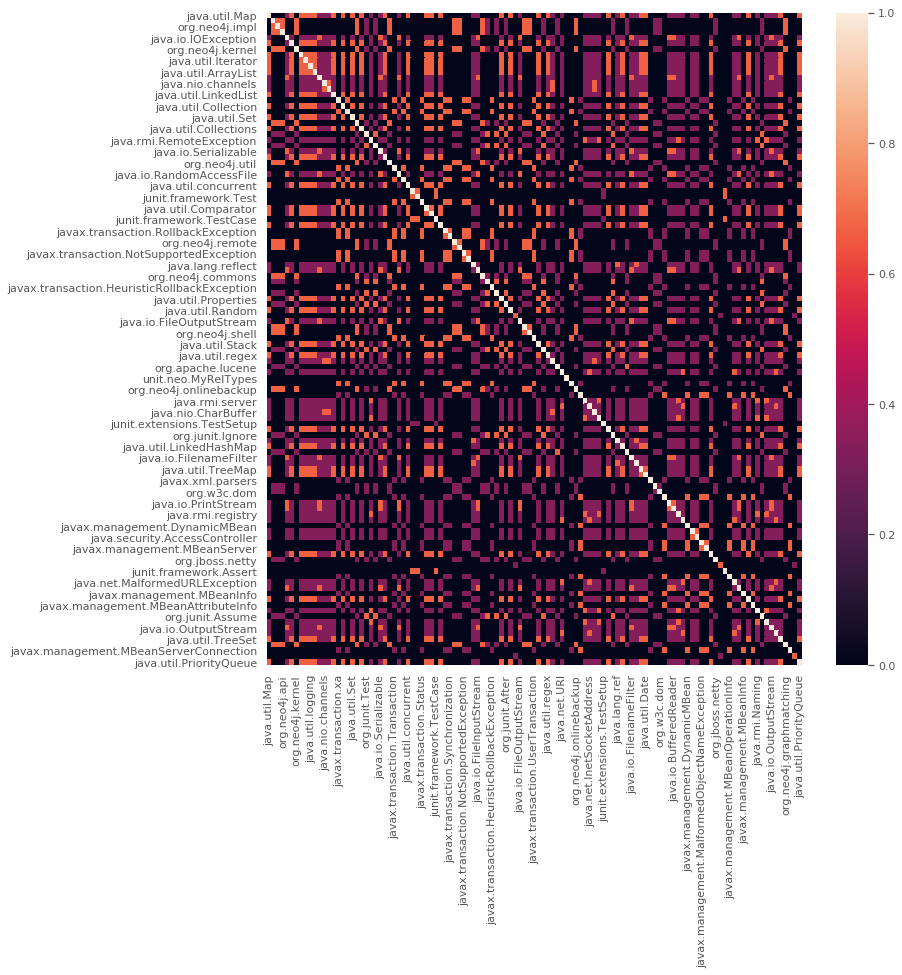

In [95]:
libraries = list(agreg_sorted.columns)
#libraries.sort()
librariy_trees = {}
def import_similarity(lib_A, lib_B):
    nodes_A = lib_A.split('.')
    nodes_B = lib_B.split('.')
    n = 0
    for node_A, node_B in zip(nodes_A, nodes_B):
        if node_A == node_B:
            n+=1
        else:
            break
    return n / library_depth

libraries_distance = pd.DataFrame(list(map(lambda x: list(map(lambda y: import_similarity(x,y), libraries)), libraries)), index=libraries, columns=libraries)
plt.figure(figsize=(12,12))
sns.heatmap(libraries_distance)
plt.plot()

# Analysis
## Summary

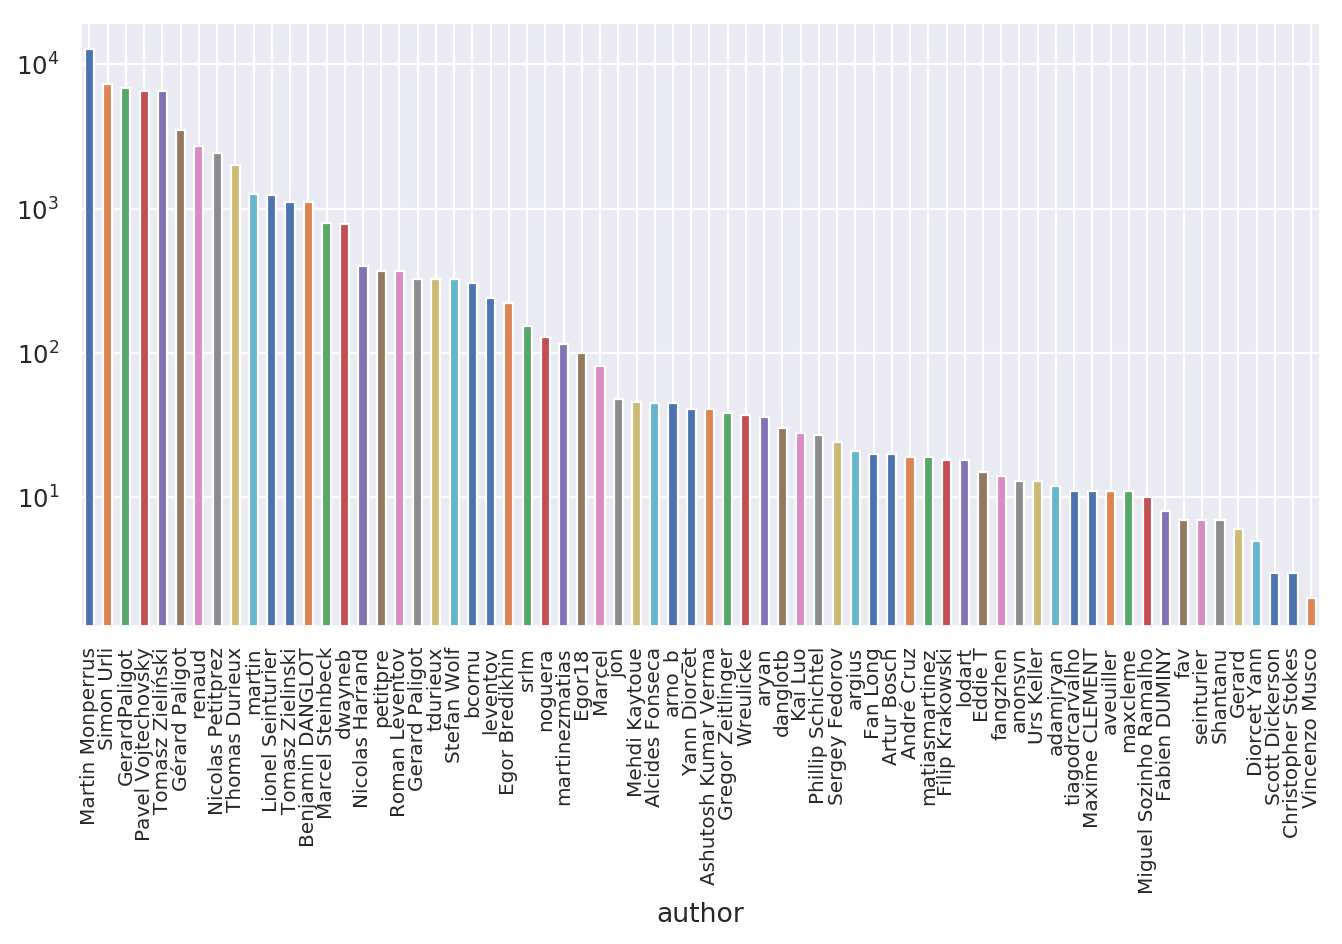

In [21]:
fig = plt.figure(figsize=(10, 5), dpi=160, facecolor='w', edgecolor='k')
number_of_contibs = agreg_sorted.sum(axis=1)
ax = number_of_contibs.plot.bar()
ax.set_yscale('log')
plt.xticks(range(len(list(number_of_contibs.index))), list(number_of_contibs.index), rotation=90, fontsize=9)
plt.show()

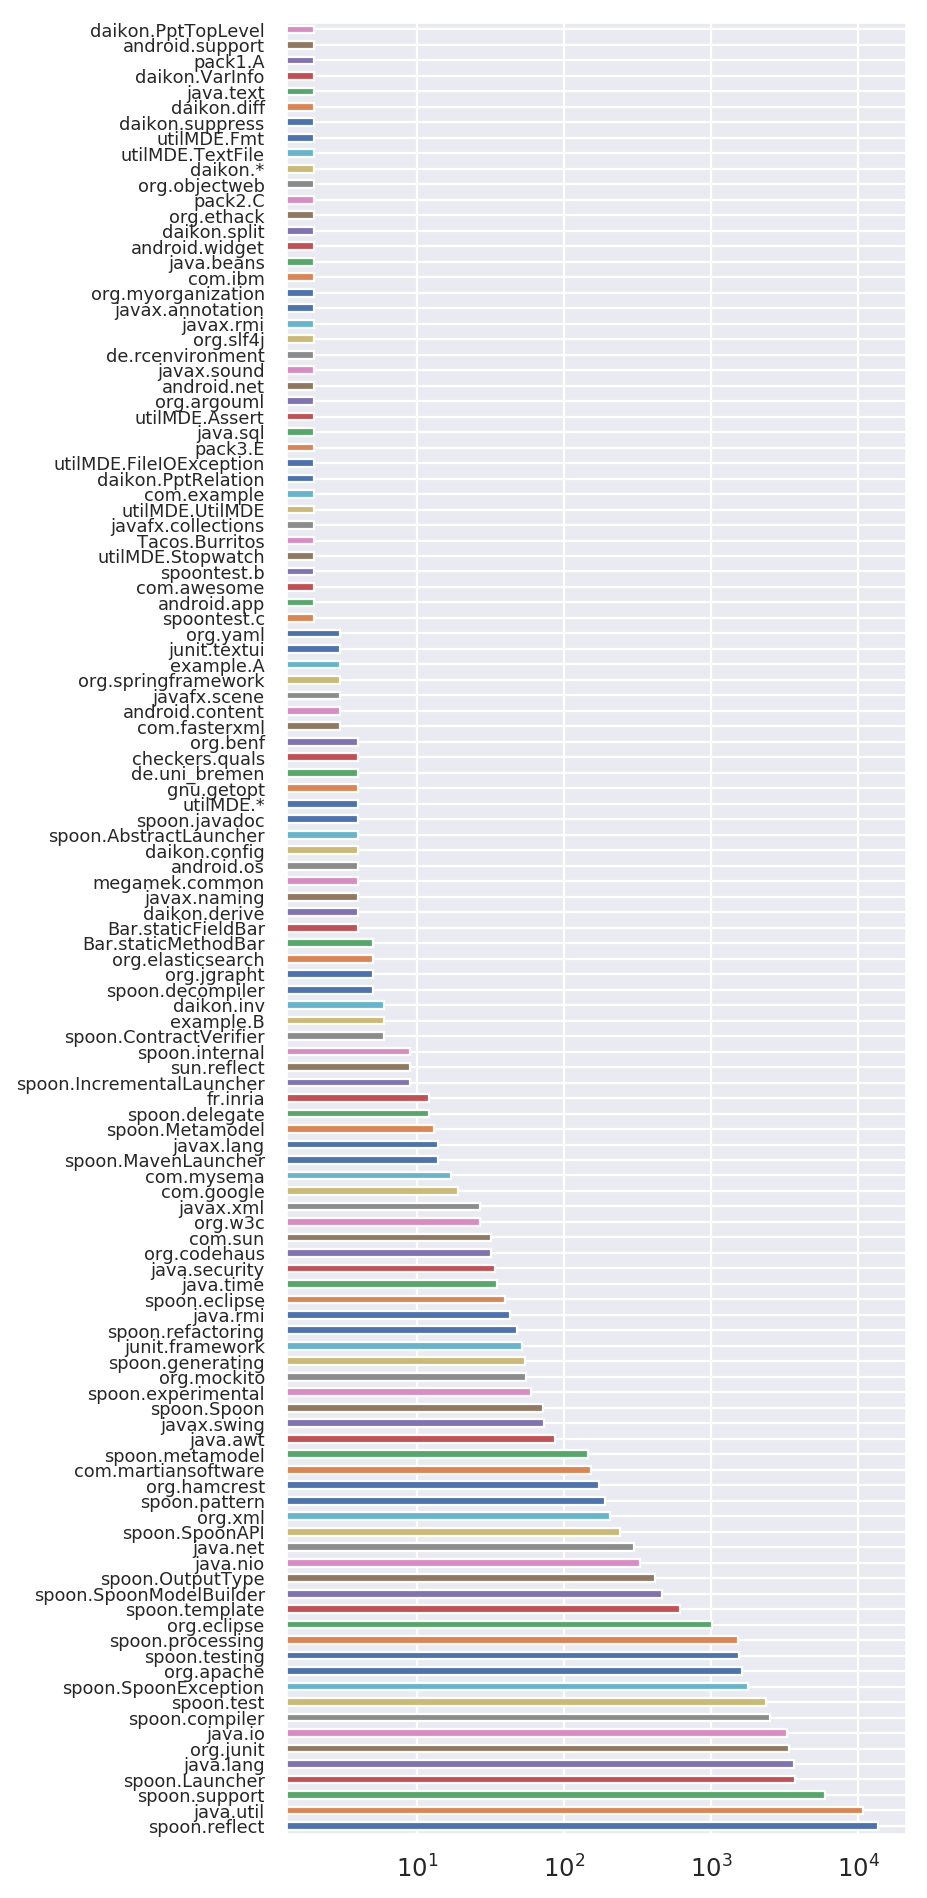

In [22]:
fig = plt.figure(figsize=(5, 15), dpi=160, facecolor='w', edgecolor='k')
number_of_imports = agreg_sorted.sum(axis=0)
ax = number_of_imports.plot.barh()
ax.set_xscale('log')
plt.yticks(range(len(list(number_of_imports.index))), list(number_of_imports.index), fontsize=8)
plt.show()

In [23]:
def plot_matrix(df, title, xlabel = '', ylabel='', log_scale=False, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize, dpi=160, facecolor='w', edgecolor='k')
    if log_scale:
        sns.heatmap(np.log10(df.add(1)))
    else:
        sns.heatmap(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.array(range(len(list(df.columns)))) + 0.5, list(df.columns), rotation=90, fontsize=9)
    plt.yticks(np.array(range(len(list(df.index)))) + 0.5, list(df.index), fontsize=9)
    plt.title(title, fontsize=24)

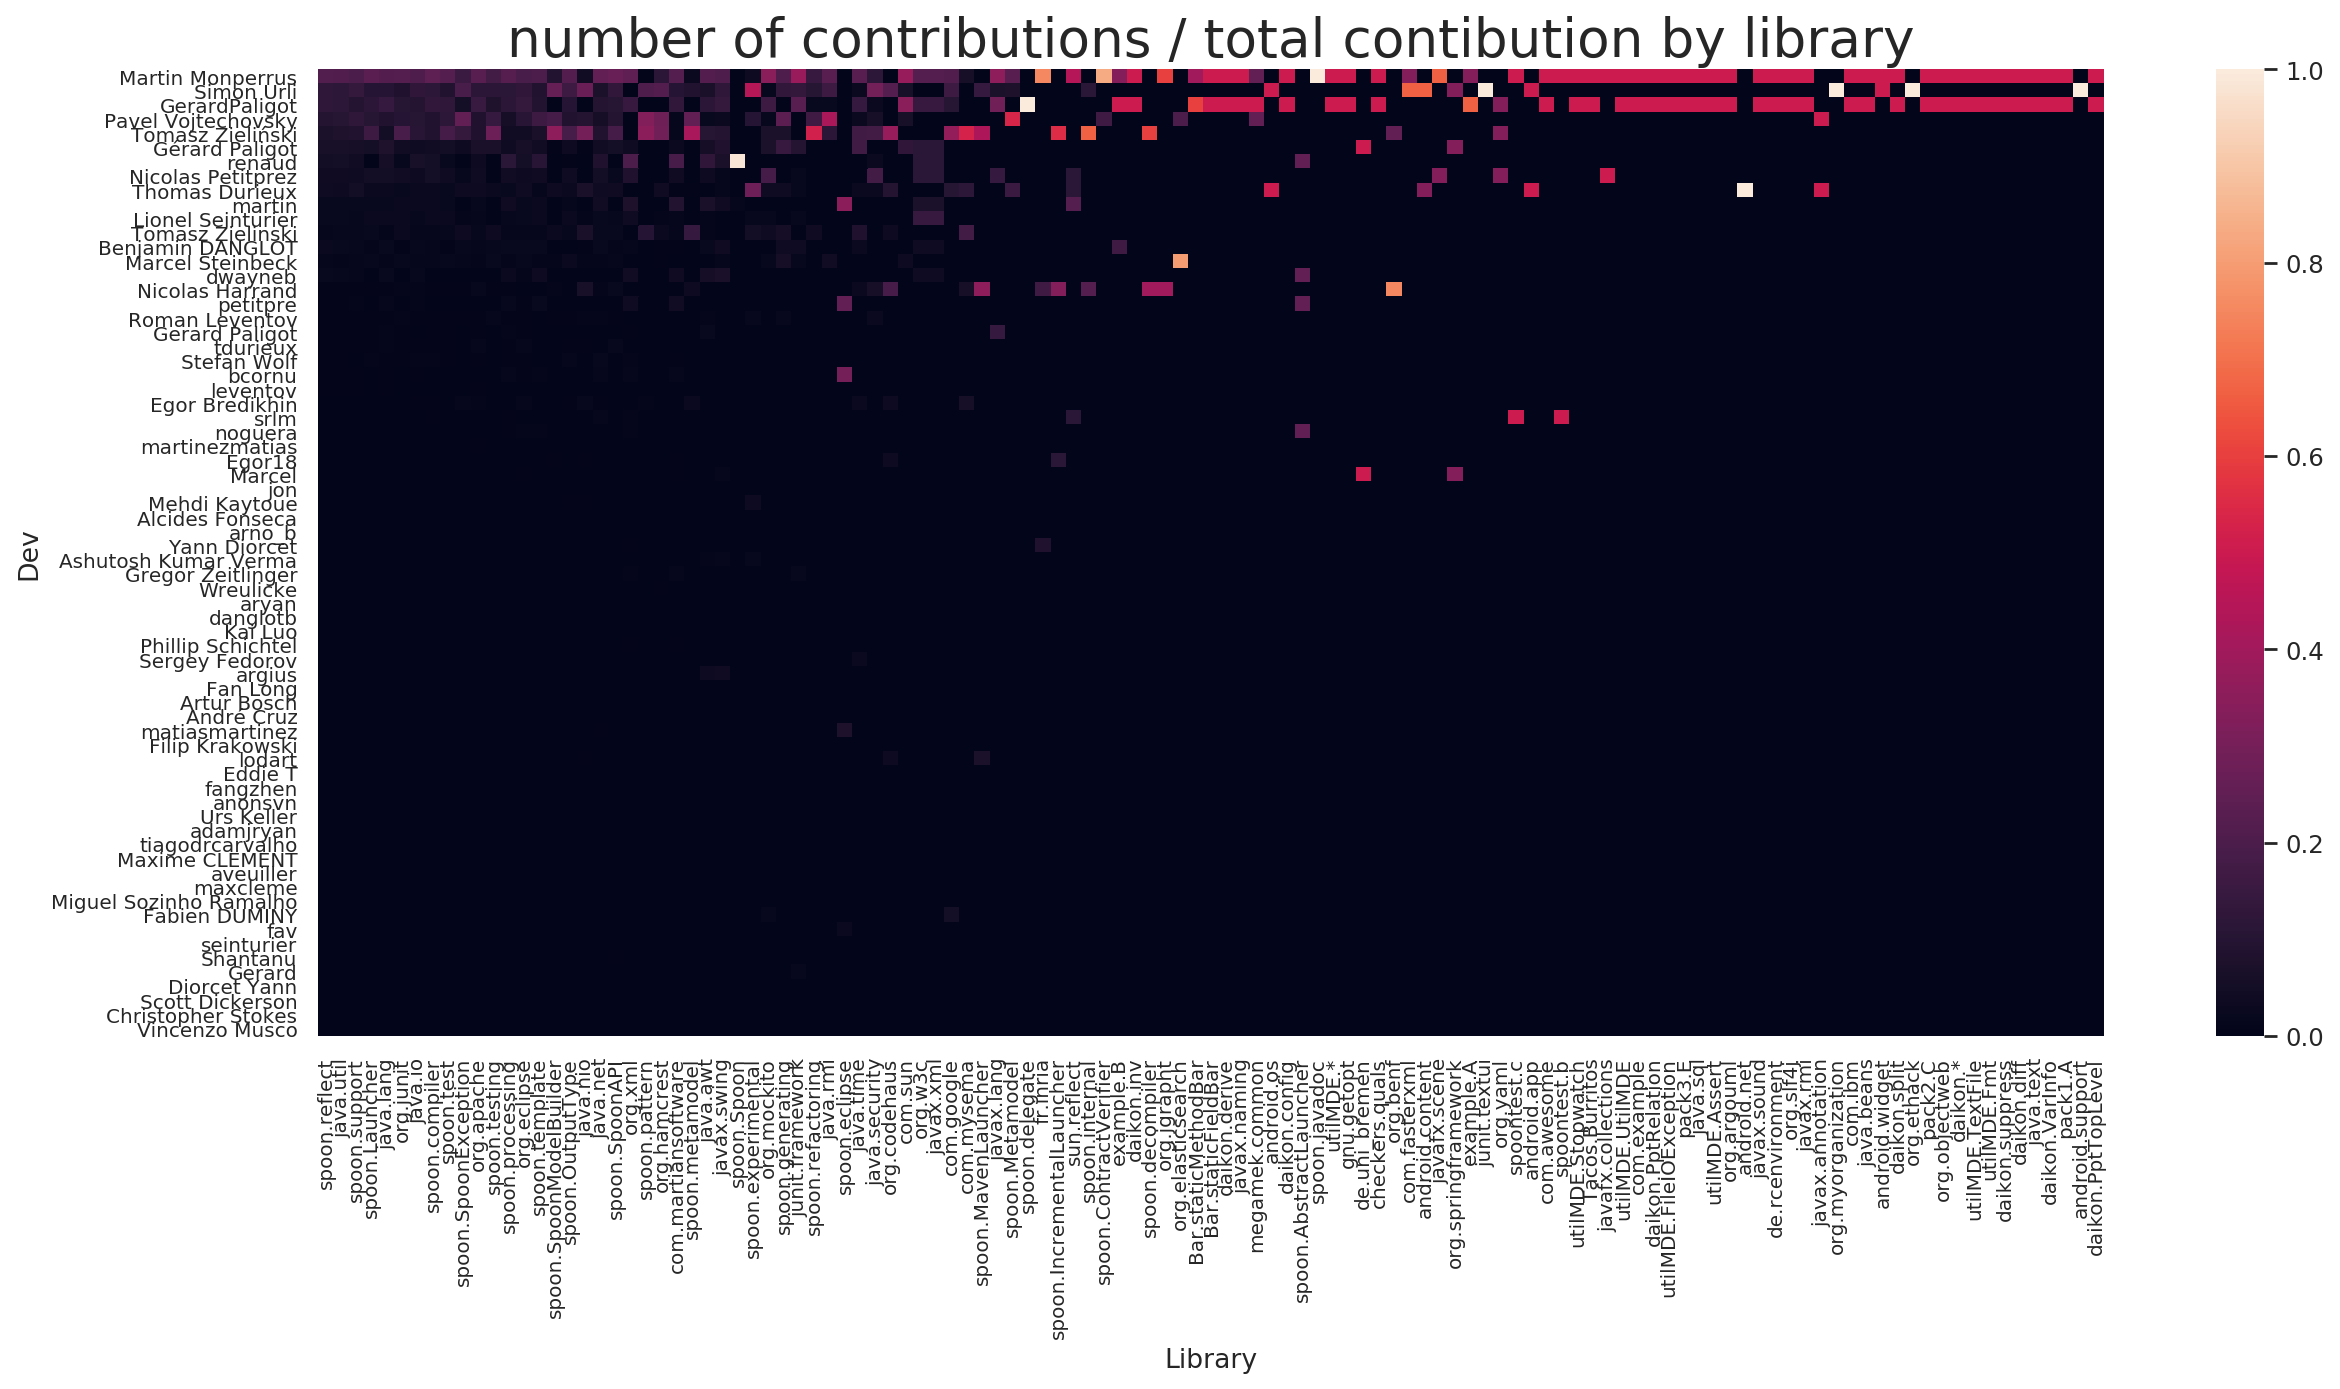

In [24]:
plot_matrix(agreg_sorted.div(agreg_sorted.sum(axis=0), axis = 1), 'number of contributions / total contibution by library', xlabel='Library', ylabel='Dev')
plt.show()

### Entropy

Mostly indicate dispersion here.

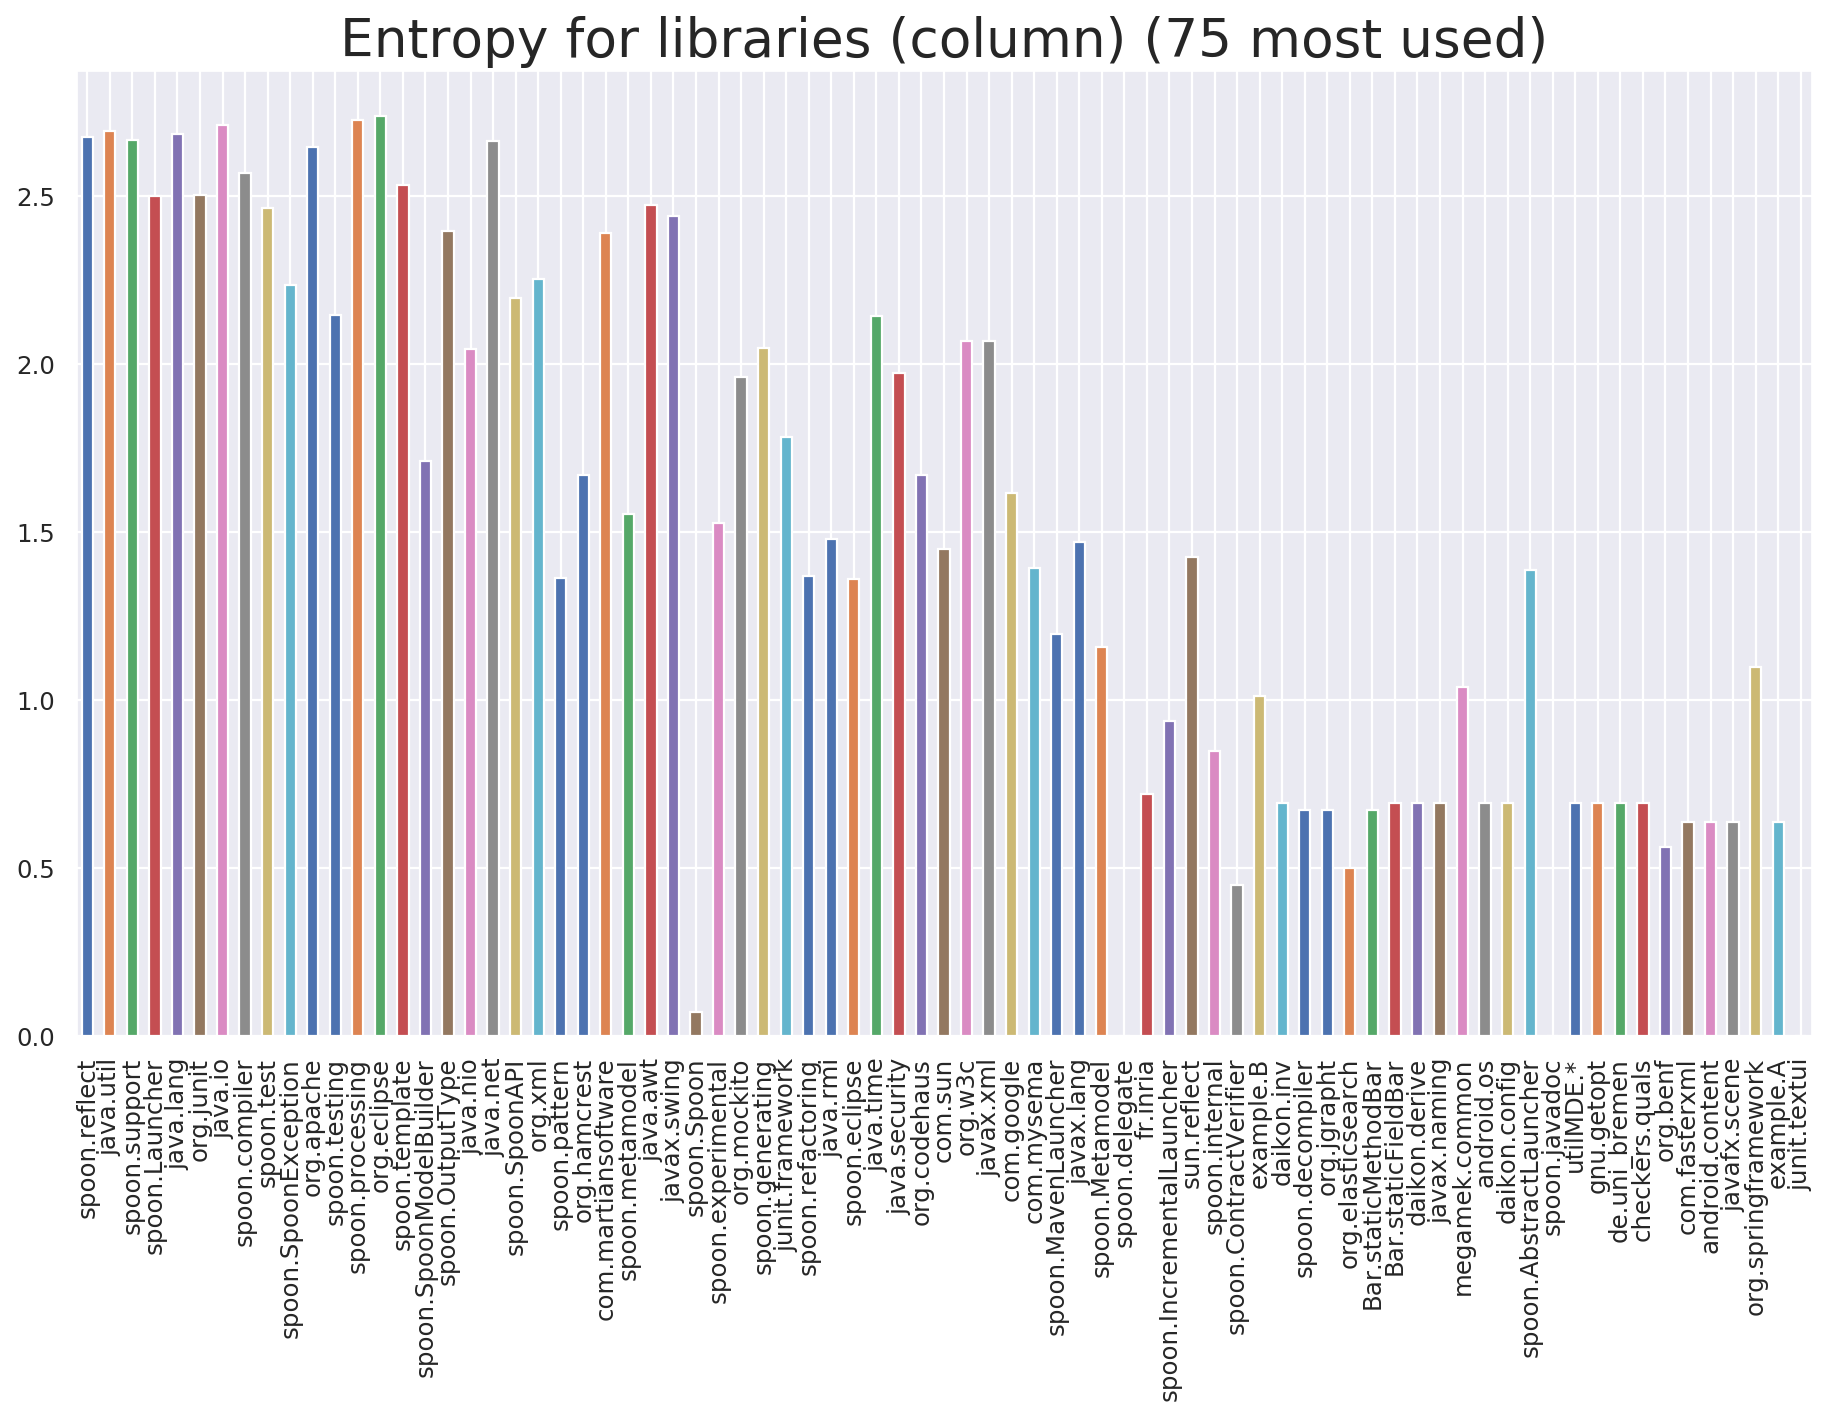

In [25]:
from scipy.stats import entropy

fig = plt.figure(figsize=(14, 8), dpi=160, facecolor='w', edgecolor='k')
#agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1))), 0).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 0).iloc[:77].plot.bar()
plt.title('Entropy for libraries (column) (75 most used)', fontsize=24)
plt.show()

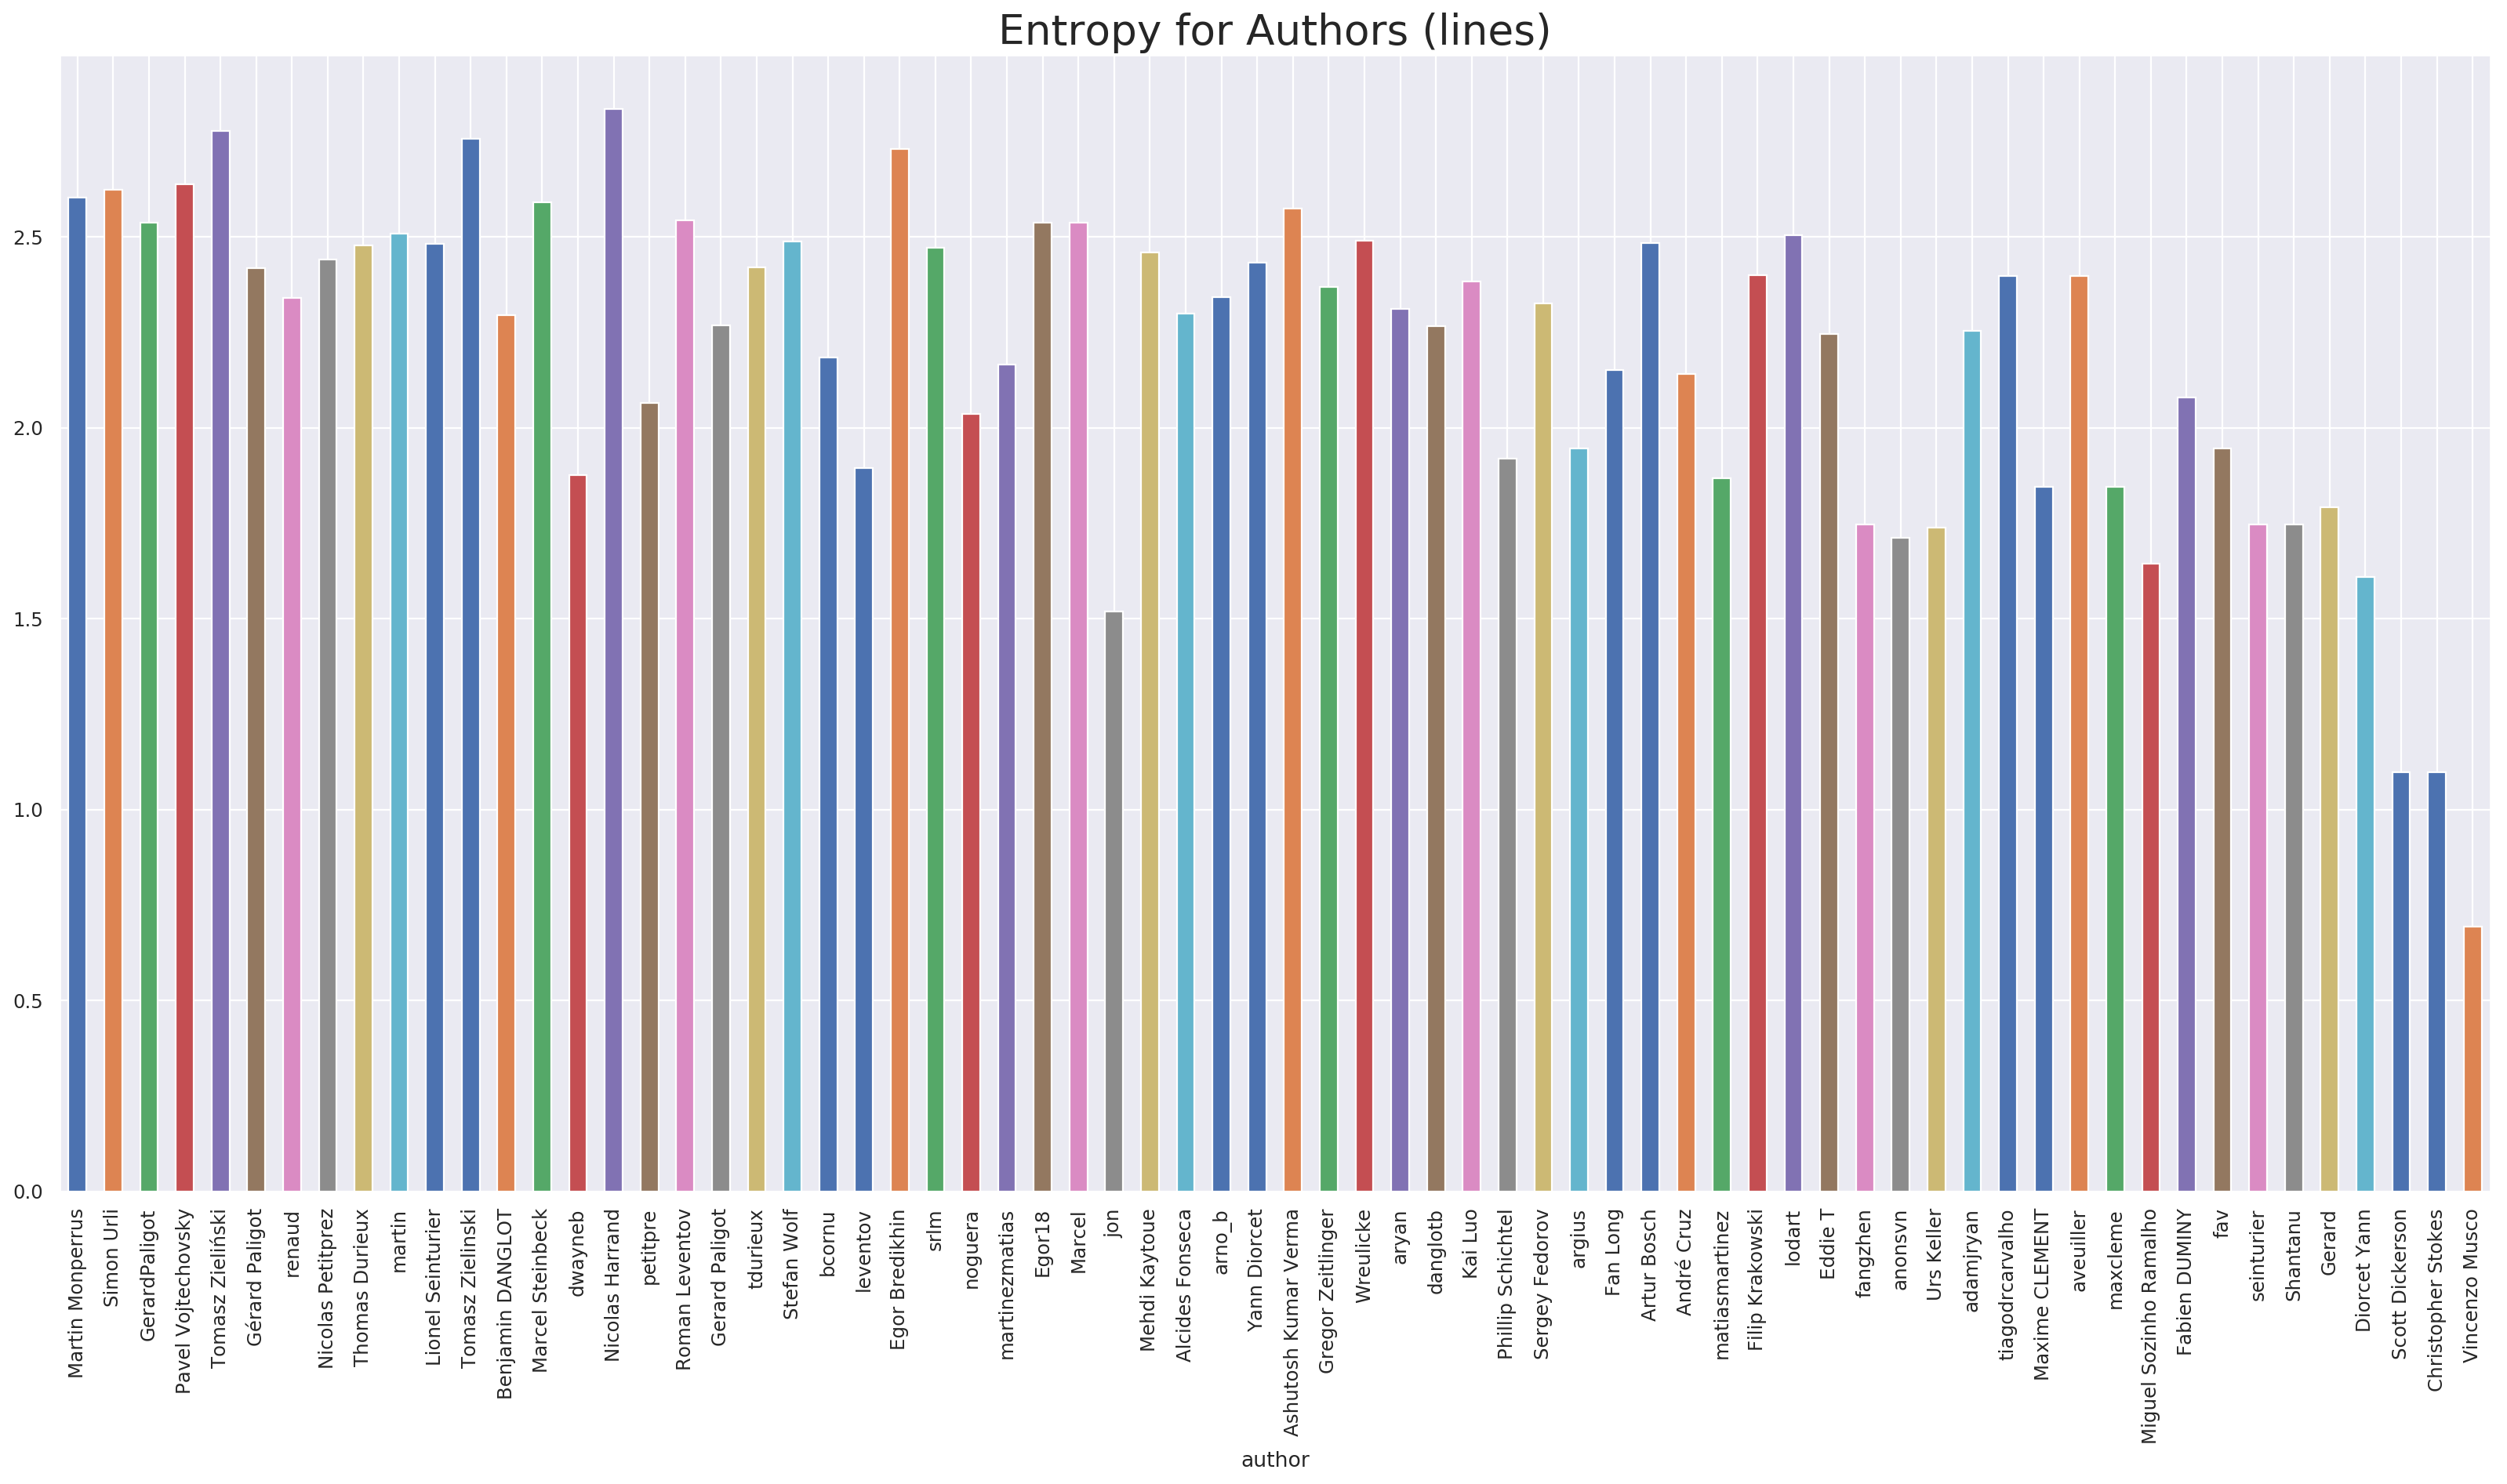

In [26]:
fig = plt.figure(figsize=(25, 12), dpi=160, facecolor='w', edgecolor='k')
# agreg_sorted.apply(lambda ligne: entropy(list(ligne.map(lambda x : int(x>=1)))), 1).plot.bar()
agreg_sorted.apply(lambda ligne: entropy(list(ligne)), 1).plot.bar()
plt.title('Entropy for Authors (lines)', fontsize=24)
plt.show()

In [27]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

def draw_vector(v0, v1, annotation='', ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='<-',
                    linewidth=1,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate(annotation, v0, v1, arrowprops=arrowprops)

def plot_pca(ax, df, pc1, pc2, pc3=None, labels=False, c=None, cmap='gnuplot', axis=None):
    if pc3 != None:
        scatter = ax.scatter(df.iloc[:,pc1], df.iloc[:,pc2], df.iloc[:,pc3], cmap=cmap, c=c)
    else:
        scatter = ax.scatter(df.iloc[:,pc1], df.iloc[:,pc2], cmap=cmap, c=c)
        if axis is not None:
            for (index, row) in axis.iterrows():
                draw_vector((0,0), (row.iloc[pc1], row.iloc[pc2]), index, ax=ax)
    if labels:
        for index, line in df.iterrows():
            if pc3 != None:
                ax.text(line.iloc[pc1], line.iloc[pc2], line.iloc[pc3], f'---{index}', fontsize=4)
            else:
                ax.text(line.iloc[pc1], line.iloc[pc2], f'---{index}', fontsize=4)
    ax.set_xlabel(f'PC{pc1+1}')
    ax.set_ylabel(f'PC{pc2+1}')
    if pc3 != None:
        ax.set_zlabel(f'PC{pc3+1}')
    return scatter

def quick_pca_plot(df, pc1, pc2, pc3=None, labels=False, c=None, cmap='gnuplot', axis=None):
    if pc3 != None:
        fig = plt.figure(figsize=(8, 6), dpi=160, constrained_layout=True)
        gs = GridSpec(2, 2, figure=fig)
        ax12 = fig.add_subplot(gs[0, 0])
        ax23 = fig.add_subplot(gs[0, 1])
        ax13 = fig.add_subplot(gs[1, 0])
        ax = fig.add_subplot(gs[1, 1], projection='3d')
        scatter3d = plot_pca(ax, df, pc1, pc2, pc3, labels=labels, c=c, cmap=cmap)
        plot_pca(ax12, df, pc1, pc2, labels=labels, c=c, cmap=cmap)
        plot_pca(ax23, df, pc2, pc3, labels=labels, c=c, cmap=cmap)
        plot_pca(ax13, df, pc1, pc3, labels=labels, c=c, cmap=cmap)
        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
        if c is not None:
            fig.colorbar(scatter3d, cax=cbar_ax)
    else:
        fig = plt.figure(figsize=(6, 6), dpi=160, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(111)
        scatter = plot_pca(ax, df, pc1, pc2, labels=labels, c=c, cmap=cmap, axis=axis)
        if c is not None:
            plt.colorbar(scatter)

## Nomalisation L2

This representation aims to represent the developpers contributions.

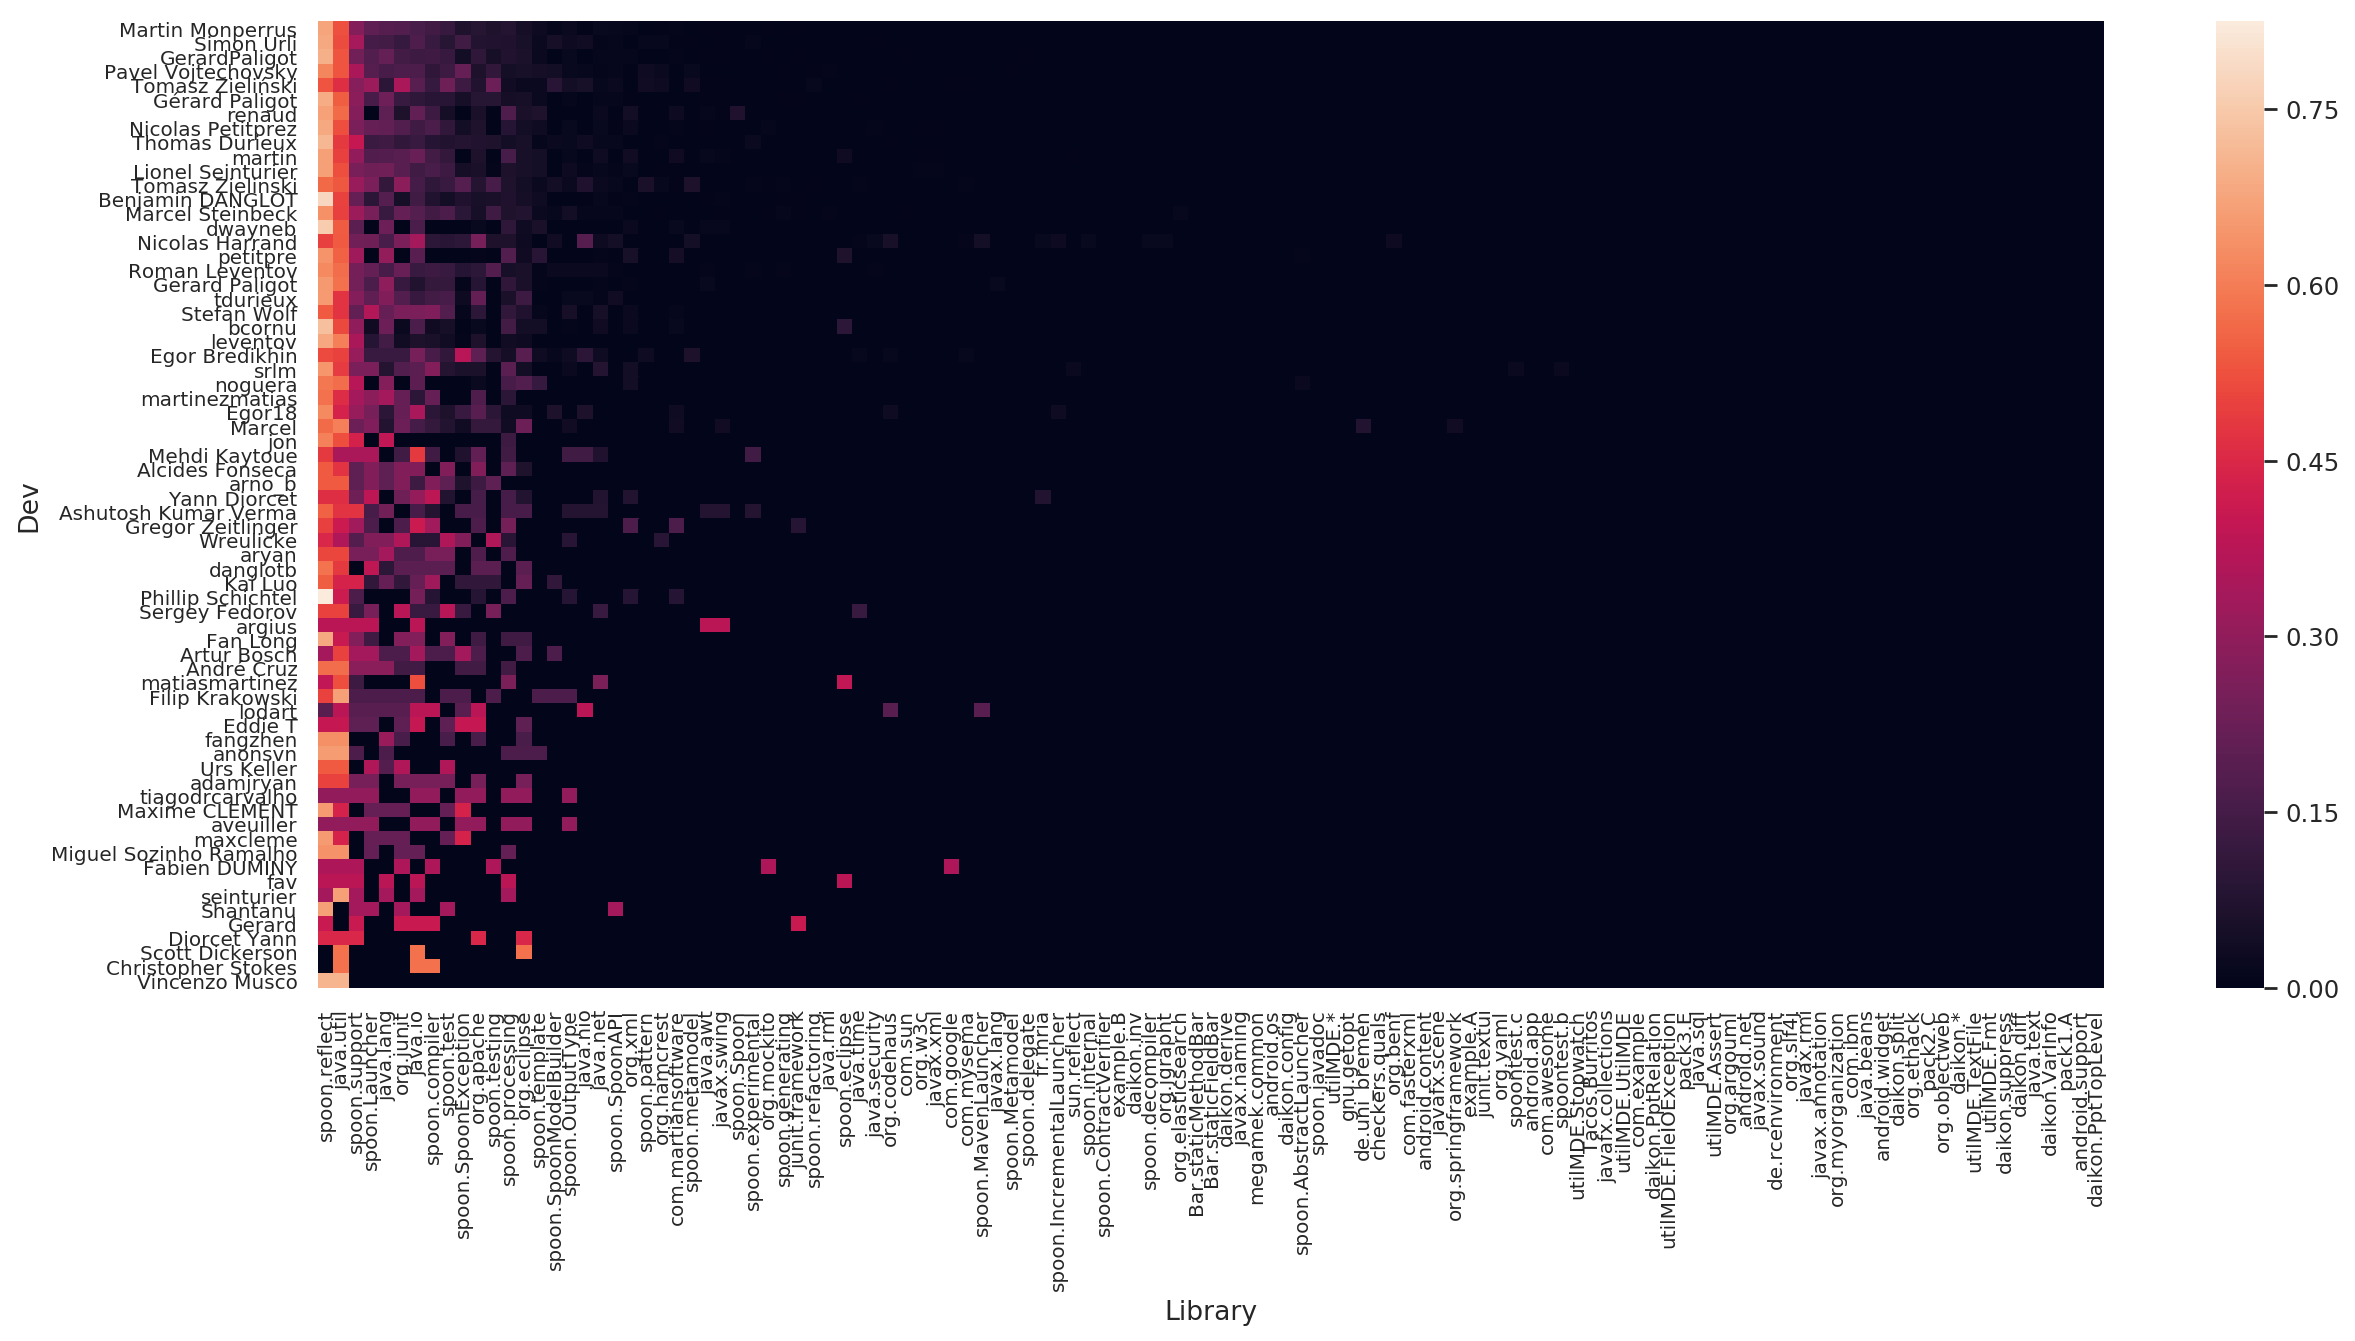

In [28]:
agreg_normalized = agreg_sorted.div(np.sqrt(agreg_sorted.pow(2).sum(axis=1)), axis=0)
plot_matrix(agreg_normalized, '', xlabel='Library', ylabel='Dev')
save_fig('author_lib_L2')
plt.show()

### PCA

Cumulative sum of the explained variance

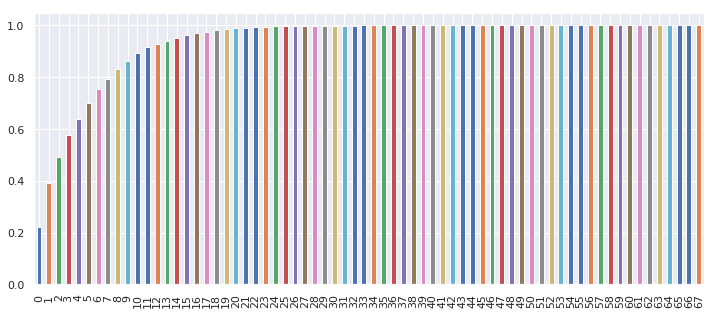

0.39249699912


In [29]:
pca = PCA()

principalComponents = pca.fit_transform(agreg_normalized)

plt.figure(figsize=(12,5))
pd.Series(np.cumsum(pca.explained_variance_ratio_)).plot.bar()
plt.show()
print(np.sum(pca.explained_variance_ratio_[:2]))

In [30]:
axis_transform = pca.transform(np.diag([1]*len(agreg_normalized.columns)))
axis_transform_df = pd.DataFrame(data = axis_transform[:,:2], index = agreg_normalized.columns
             , columns = ['principal component 1', 'principal component 2'])

principalDf = pd.DataFrame(data = principalComponents[:,:3], index = agreg_normalized.index
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

axis_transform_df_top = axis_transform_df[np.sqrt(axis_transform_df.pow(2).sum(axis=1)) > 0.35]


In [31]:
from sklearn.cluster import KMeans # or GaussianMixture ? 


top = principalDf.loc[number_of_contibs > 100]
top_agreg = agreg_normalized.loc[number_of_contibs > 100]

n_clusters = 4
colors = plt.cm.get_cmap('Set2', n_clusters)

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(top_agreg)

y_kmeans = kmeans.predict(top_agreg)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2117: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


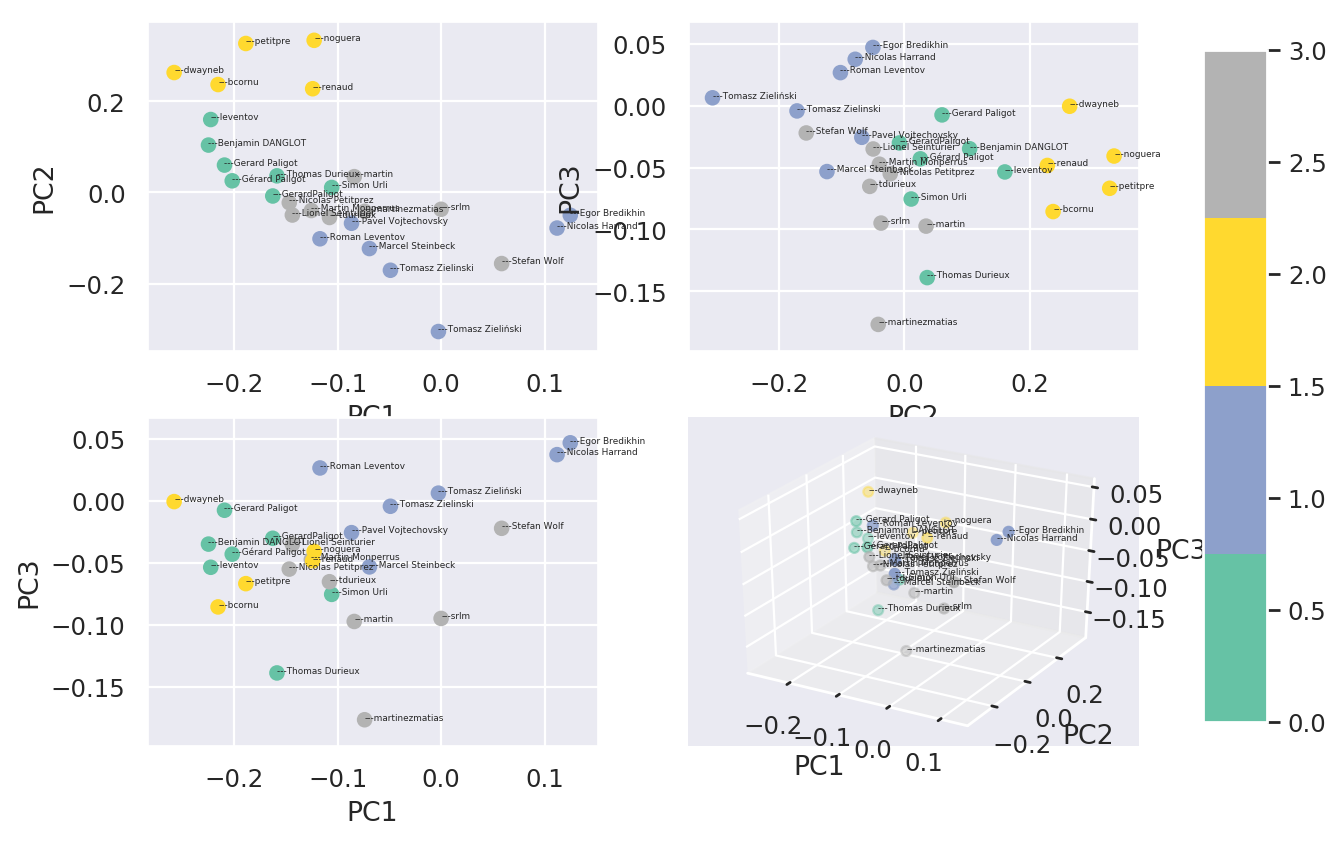

In [32]:
quick_pca_plot(top , 0, 1, 2, labels=True, c=y_kmeans, cmap=colors)
plt.show()

In [ ]:
top_avg_contib = avg_contrib.loc[top.index, 'index'].loc[:,'mean']

In [ ]:
plt.figure(figsize=(10,10))
data = {
    'pc1': top['principal component 1'],
    'pc2': top['principal component 2'],
    'avg_contib': top_avg_contib,
    'cluster': y_kmeans,
    'Number of commits': avg_contrib.loc[top.index, 'index'].loc[:,'count'].values
}
cmap = sns.cubehelix_palette(as_cmap=True)
scatter = sns.scatterplot(x='pc1',y='pc2', data = data, hue = 'avg_contib', palette='viridis', style='cluster', size='Number of commits', sizes=(100, 400))
center_x = -0.17
center_y = -0.03
for index, line in top.iterrows():
    pos_x = line.loc['principal component 1']
    pos_y = line.loc['principal component 2']
    norm = np.sqrt((pos_x-center_x)**2 + (pos_y-center_y)**2)
    offset_x = (pos_x-center_x)/norm * 0.04
    offset_y = (pos_y-center_y)/norm * 0.04
    offset_text_x = (pos_x-center_x)/norm * 0.0475
    offset_text_y = (pos_y-center_y)/norm * 0.0475
    horizontalalignment = 'center'
    if abs(offset_y/offset_x) < 0.5:
        horizontalalignment = 'right' if offset_x<0 else 'left'
        offset_text_y = offset_y
        offset_text_x = offset_x
    text_value = f'{index}'
    l = mlines.Line2D([pos_x,pos_x+offset_x], [pos_y,pos_y + offset_y], color='#444444')
    scatter.add_line(l)
    t = scatter.text(pos_x + offset_text_x, pos_y + offset_text_y, text_value, fontsize=12, va='center',horizontalalignment=horizontalalignment)
save_fig('PCA_all')
plt.show()

### Ordered by clusters

In [ ]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=100).fit(top_agreg)
y_kmeans = kmeans.predict(top_agreg)
index_cluster = np.array(kmeans.labels_).argsort()

plot_matrix(np.log(1+top_agreg.iloc[index_cluster]), title='', figsize=(18,3))

### Scalar product (similarity of work) 

In [ ]:
agreg_product = pd.DataFrame(np.matrix(top_agreg) * np.transpose(np.matrix(top_agreg)))
agreg_product.index = top_agreg.index
agreg_product.columns = top_agreg.index

sns.clustermap(agreg_product)
save_fig('similarity_clustermap')
plt.plot();

## Normalisation expertise

First we divide by the total number of imports per library and then we normalize (L2) on the devs.

The goal is to have a vector that would represent it's expertise.

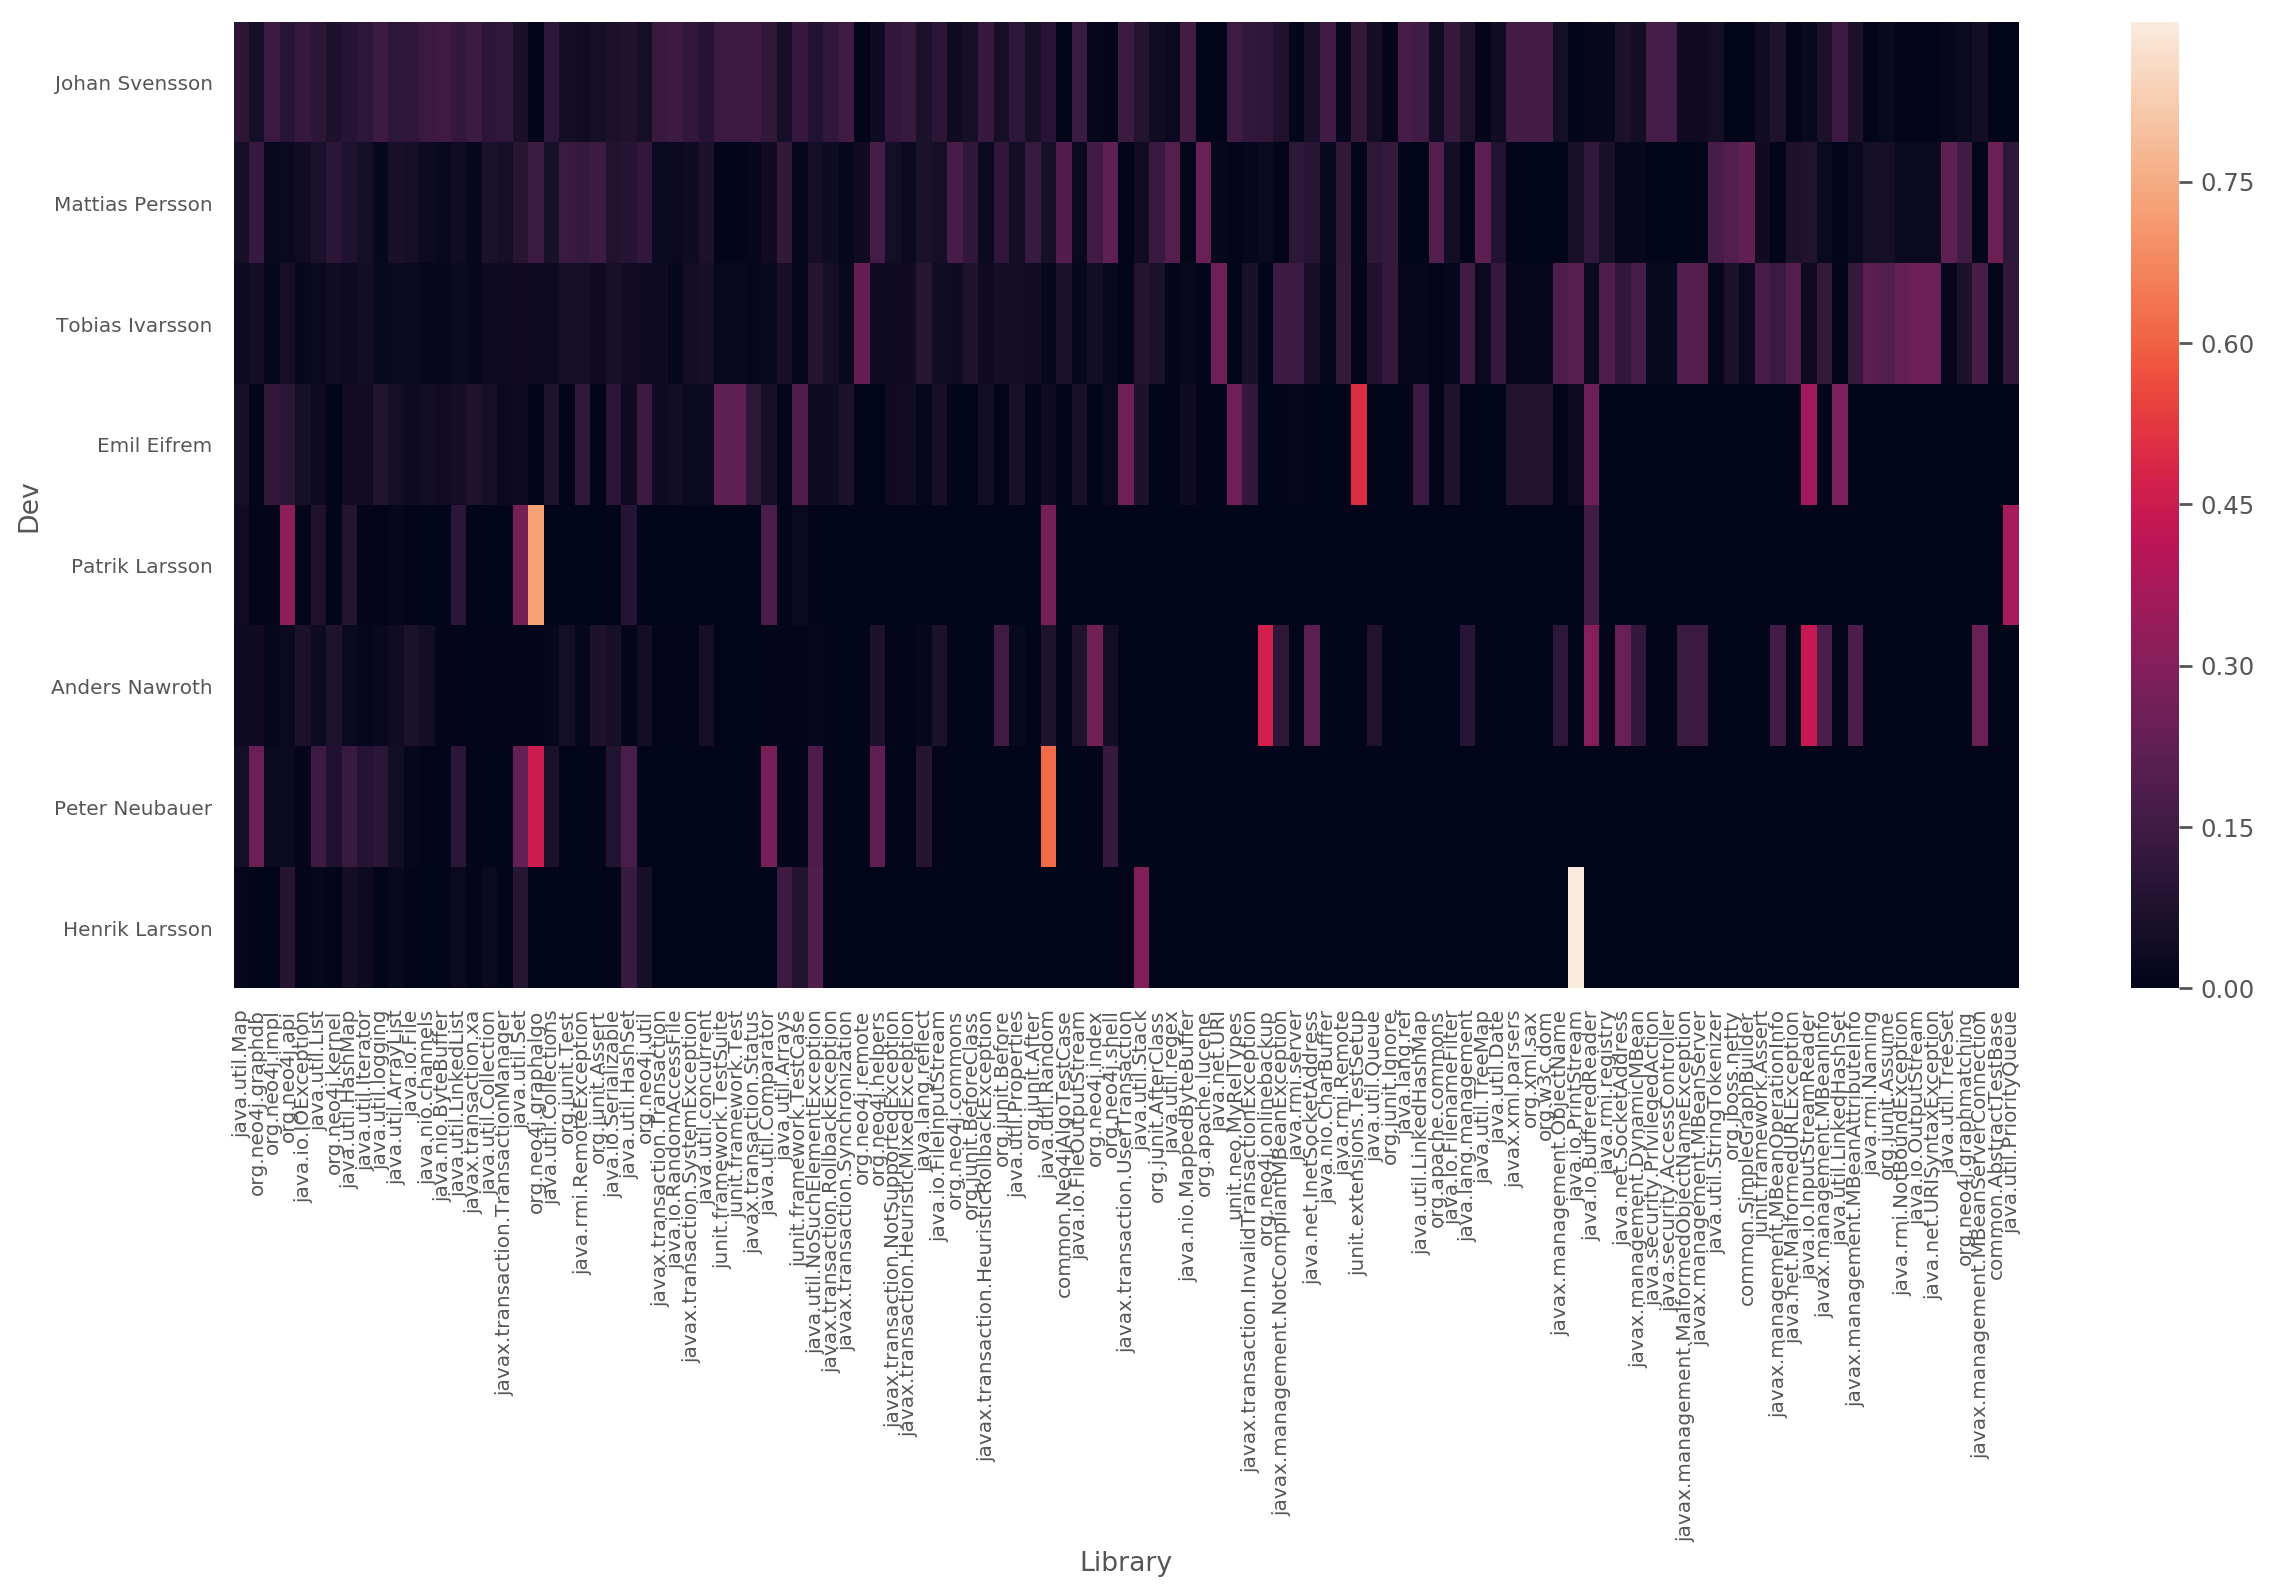

In [64]:
agreg_normalized_2 = agreg_sorted.div(agreg_sorted.sum(axis=0), axis = 1)
agreg_normalized_2 = agreg_normalized_2.div(np.sqrt(agreg_normalized_2.pow(2).sum(axis=1)), axis=0)
plot_matrix(agreg_normalized_2, '', xlabel='Library', ylabel='Dev')
plt.show()

### Scalar product (similarity of expertise)

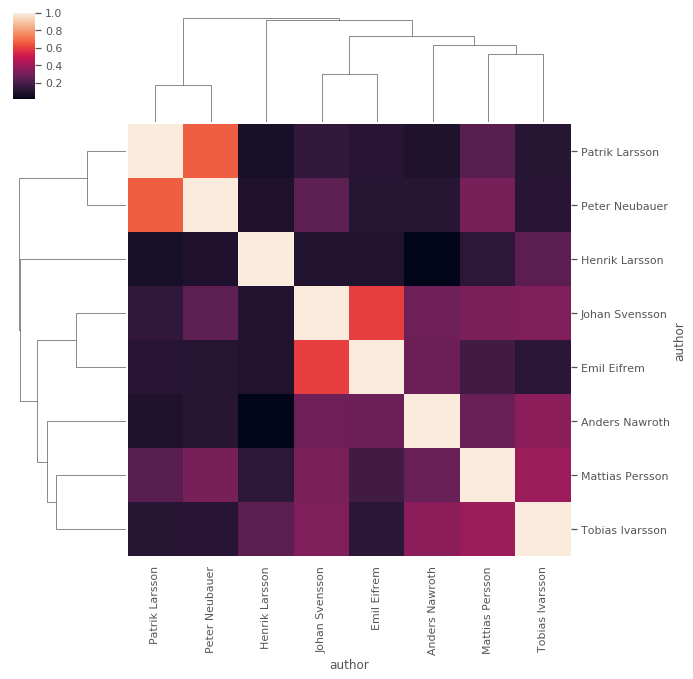

In [65]:
agreg_product_2 = pd.DataFrame(np.matrix(agreg_normalized_2) * np.transpose(np.matrix(agreg_normalized_2)))
agreg_product_2.index = agreg_normalized_2.index
agreg_product_2.columns = agreg_normalized_2.index

sns.clustermap(agreg_product_2)
save_fig('similarity_clustermap')
plt.plot();

### Co-Clust

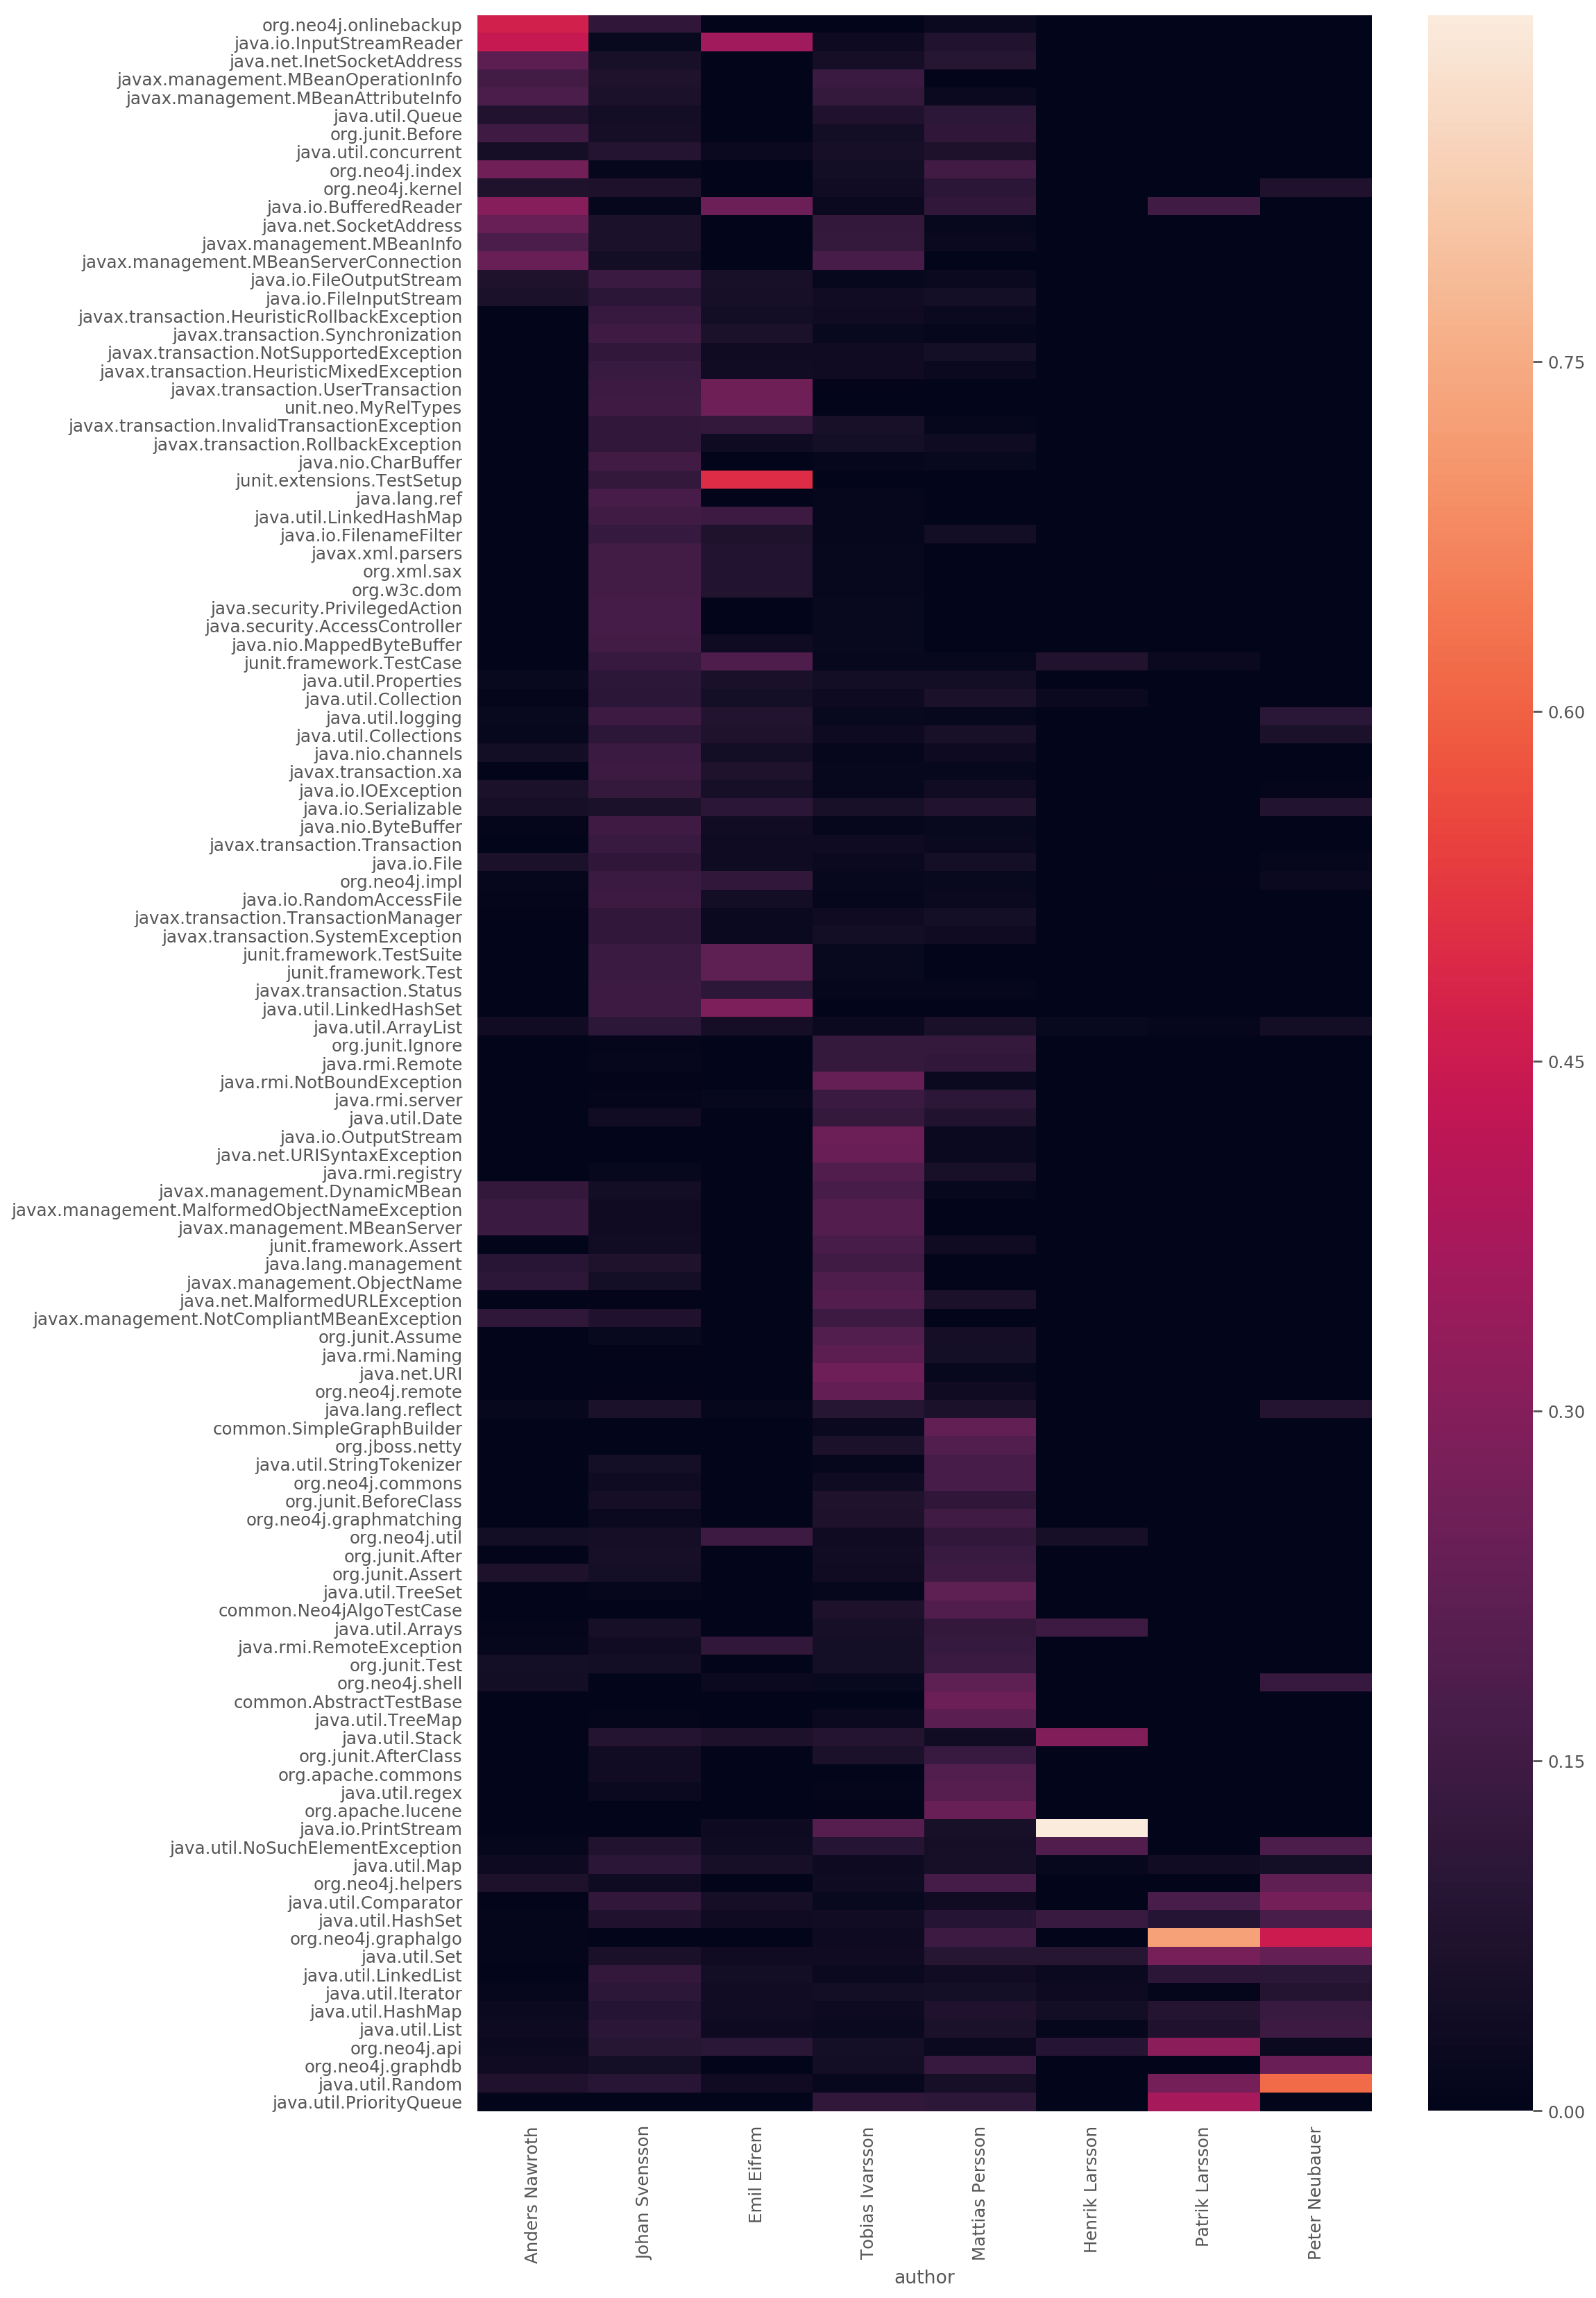

In [77]:
from coclust.coclustering import (CoclustMod, CoclustSpecMod, CoclustInfo)
from coclust.visualization import plot_reorganized_matrix

model = CoclustMod(n_clusters = 5, n_init = 20)
model.fit(np.matrix(agreg_normalized_2))
fit_data = agreg_normalized_2.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

plt.figure(figsize=(13,25), dpi=160)
sns.heatmap(fit_data.transpose())
plt.show()